In [ ]:
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

In [ ]:
import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Define the Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.out = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

# Replay Buffer to store experiences
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return np.array(state), action, reward, np.array(next_state), done

    def __len__(self):
        return len(self.buffer)

# Hyperparameters
ENV_NAME = 'CartPole-v1'
EPISODES = 500             # Number of training episodes
BATCH_SIZE = 64
GAMMA = 0.99               # Discount factor
LR = 1e-3                  # Learning rate
EPS_START = 1.0            # Starting value of epsilon (exploration)
EPS_END = 0.01             # Final value of epsilon
EPS_DECAY = 0.995          # Decay factor per episode
TARGET_UPDATE = 10         # Update target network every TARGET_UPDATE episodes
MEMORY_CAPACITY = 10000    # Replay buffer size

def train():
    env = gym.make(ENV_NAME)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # Create the policy and target networks
    policy_net = QNetwork(state_dim, action_dim)
    target_net = QNetwork(state_dim, action_dim)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    memory = ReplayBuffer(MEMORY_CAPACITY)
    epsilon = EPS_START

    for episode in range(EPISODES):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                with torch.no_grad():
                    q_values = policy_net(state_tensor)
                action = q_values.max(1)[1].item()

            # Take the action in the environment
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            # Store the transition in memory
            memory.push(state, action, reward, next_state, done)
            state = next_state

            # Update the policy network once we have enough samples
            if len(memory) > BATCH_SIZE:
                states, actions, rewards, next_states, dones = memory.sample(BATCH_SIZE)
                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions).unsqueeze(1)
                rewards = torch.FloatTensor(rewards).unsqueeze(1)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones).unsqueeze(1)

                # Compute current Q values
                q_values = policy_net(states).gather(1, actions)

                # Compute target Q values using the target network
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
                expected_q_values = rewards + GAMMA * next_q_values * (1 - dones)

                # Compute the loss
                loss = nn.MSELoss()(q_values, expected_q_values)

                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Decay the exploration rate
        epsilon = max(EPS_END, epsilon * EPS_DECAY)

        # Update the target network every few episodes
        if episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    env.close()
    return policy_net

def simulate(policy_net, num_episodes=5):
    # Run a few episodes to see the trained agent in action
    env = gym.make(ENV_NAME)
    for i in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            env.render()
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = policy_net(state_tensor)
            action = q_values.max(1)[1].item()
            state, _, done, _ = env.step(action)
        print(f"Simulation Episode {i + 1} completed.")
    env.close()

if __name__ == '__main__':
    trained_policy = train()
    simulate(trained_policy)

Episode 0, Reward: 10.0, Epsilon: 0.995
Episode 1, Reward: 33.0, Epsilon: 0.990
Episode 2, Reward: 17.0, Epsilon: 0.985
Episode 3, Reward: 63.0, Epsilon: 0.980
Episode 4, Reward: 28.0, Epsilon: 0.975
Episode 5, Reward: 18.0, Epsilon: 0.970
Episode 6, Reward: 18.0, Epsilon: 0.966
Episode 7, Reward: 19.0, Epsilon: 0.961
Episode 8, Reward: 11.0, Epsilon: 0.956
Episode 9, Reward: 52.0, Epsilon: 0.951
Episode 10, Reward: 14.0, Epsilon: 0.946
Episode 11, Reward: 20.0, Epsilon: 0.942
Episode 12, Reward: 11.0, Epsilon: 0.937
Episode 13, Reward: 12.0, Epsilon: 0.932
Episode 14, Reward: 9.0, Epsilon: 0.928
Episode 15, Reward: 16.0, Epsilon: 0.923
Episode 16, Reward: 43.0, Epsilon: 0.918
Episode 17, Reward: 11.0, Epsilon: 0.914
Episode 18, Reward: 10.0, Epsilon: 0.909
Episode 19, Reward: 11.0, Epsilon: 0.905
Episode 20, Reward: 17.0, Epsilon: 0.900
Episode 21, Reward: 21.0, Epsilon: 0.896
Episode 22, Reward: 13.0, Epsilon: 0.891
Episode 23, Reward: 22.0, Epsilon: 0.887
Episode 24, Reward: 11.0, E

/usr/local/lib/python3.11/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_reso

Simulation Episode 1 completed.
Simulation Episode 2 completed.
Simulation Episode 3 completed.
Simulation Episode 4 completed.
Simulation Episode 5 completed.


## Cart Pole with Dynamic change in enviroments
Aleatoric uncertainty refers to the inherent randomness or noise that is part of the environment and measurements. In the CartPole setup, some possible ways to introduce aleatoric uncertainty include:

Sensor/Observation Noise:
Add random noise (e.g., Gaussian noise) to the state variables the agent observes (cart position, velocity, pole angle, and angular velocity). This simulates imprecise sensors.

Actuation/Control Noise:
Perturb the actions applied to the environment. For instance, if the agent commands a force, you can add random variations so that the applied force isn’t exactly what was intended.

Environmental Parameter Variability:
Introduce stochastic variations in the dynamics of the environment. For example, randomly vary physical parameters such as the mass of the cart or pole, the length of the pole, friction coefficients, or even the gravity constant from episode to episode.

External Disturbances:
Apply random external forces or impulses to the system (e.g., wind gusts or sudden pushes on the cart) during simulation. This can mimic real-world disturbances that the agent might encounter.

In [ ]:
import gym
from IPython import display
import io
import base64
import torch

def record_simulation(policy_net, video_folder='./video', video_length=500):
    # Create the environment with a render_mode (e.g., 'rgb_array') and new_step_api enabled.
    env = gym.make('CartPole-v1', render_mode='rgb_array', new_step_api=True)
    env = gym.wrappers.RecordVideo(env, video_folder, episode_trigger=lambda episode_id: True)

    # Use a more flexible reset handling in case the returned tuple structure varies
    reset_result = env.reset()
    if isinstance(reset_result, tuple):
        state = reset_result[0]
    else:
        state = reset_result

    for t in range(video_length):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = policy_net(state_tensor)
        action = q_values.max(1)[1].item()

        # With new_step_api, step returns (observation, reward, done, truncated, info)
        step_result = env.step(action)
        if len(step_result) == 5:
            state, reward, done, truncated, info = step_result
            done = done or truncated
        else:
            state, reward, done, info = step_result

        if done:
            break

    env.close()

def show_video(video_path):
    # Read and display the video in Colab
    video_file = open(video_path, "rb").read()
    video_b64 = base64.b64encode(video_file).decode("ascii")
    video_html = f'''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{video_b64}" type="video/mp4">
    </video>
    '''
    return display.HTML(video_html)

# Example usage:
# Assuming 'trained_policy' is your trained network from the training phase
record_simulation(trained_policy)

import os
print("Recorded video files:", os.listdir('./video'))

# Adjust the file name based on the output directory listing.
video_path = './video/rl-video-episode-0.mp4'
show_video(video_path)


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Recorded video files: ['rl-video-episode-0.mp4', 'rl-video-episode-0.meta.json']



Training with Base uncertainty:
Episode 0, Reward: 23.00, Epsilon: 0.995
Episode 1, Reward: 22.00, Epsilon: 0.990
Episode 2, Reward: 12.00, Epsilon: 0.985
Episode 3, Reward: 9.00, Epsilon: 0.980
Episode 4, Reward: 63.00, Epsilon: 0.975
Episode 5, Reward: 13.00, Epsilon: 0.970
Episode 6, Reward: 17.00, Epsilon: 0.966
Episode 7, Reward: 11.00, Epsilon: 0.961
Episode 8, Reward: 11.00, Epsilon: 0.956
Episode 9, Reward: 17.00, Epsilon: 0.951
Episode 10, Reward: 13.00, Epsilon: 0.946
Episode 11, Reward: 24.00, Epsilon: 0.942
Episode 12, Reward: 67.00, Epsilon: 0.937
Episode 13, Reward: 26.00, Epsilon: 0.932
Episode 14, Reward: 19.00, Epsilon: 0.928
Episode 15, Reward: 16.00, Epsilon: 0.923
Episode 16, Reward: 19.00, Epsilon: 0.918
Episode 17, Reward: 16.00, Epsilon: 0.914
Episode 18, Reward: 12.00, Epsilon: 0.909
Episode 19, Reward: 25.00, Epsilon: 0.905
Episode 20, Reward: 13.00, Epsilon: 0.900
Episode 21, Reward: 23.00, Epsilon: 0.896
Episode 22, Reward: 70.00, Epsilon: 0.891
Episode 23, 

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning:

WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.



Episode 9, Reward: 18.00, Epsilon: 0.951
Episode 10, Reward: 13.00, Epsilon: 0.946
Episode 11, Reward: 19.00, Epsilon: 0.942
Episode 12, Reward: 13.00, Epsilon: 0.937
Episode 13, Reward: 20.00, Epsilon: 0.932
Episode 14, Reward: 18.00, Epsilon: 0.928
Episode 15, Reward: 19.00, Epsilon: 0.923
Episode 16, Reward: 30.00, Epsilon: 0.918
Episode 17, Reward: 11.00, Epsilon: 0.914
Episode 18, Reward: 16.00, Epsilon: 0.909
Episode 19, Reward: 15.00, Epsilon: 0.905
Episode 20, Reward: 15.00, Epsilon: 0.900
Episode 21, Reward: 19.00, Epsilon: 0.896
Episode 22, Reward: 32.00, Epsilon: 0.891
Episode 23, Reward: 9.00, Epsilon: 0.887
Episode 24, Reward: 14.00, Epsilon: 0.882
Episode 25, Reward: 10.00, Epsilon: 0.878
Episode 26, Reward: 17.00, Epsilon: 0.873
Episode 27, Reward: 13.00, Epsilon: 0.869
Episode 28, Reward: 21.00, Epsilon: 0.865
Episode 29, Reward: 9.00, Epsilon: 0.860
Episode 30, Reward: 9.00, Epsilon: 0.856
Episode 31, Reward: 12.00, Epsilon: 0.852
Episode 32, Reward: 9.00, Epsilon: 0.8

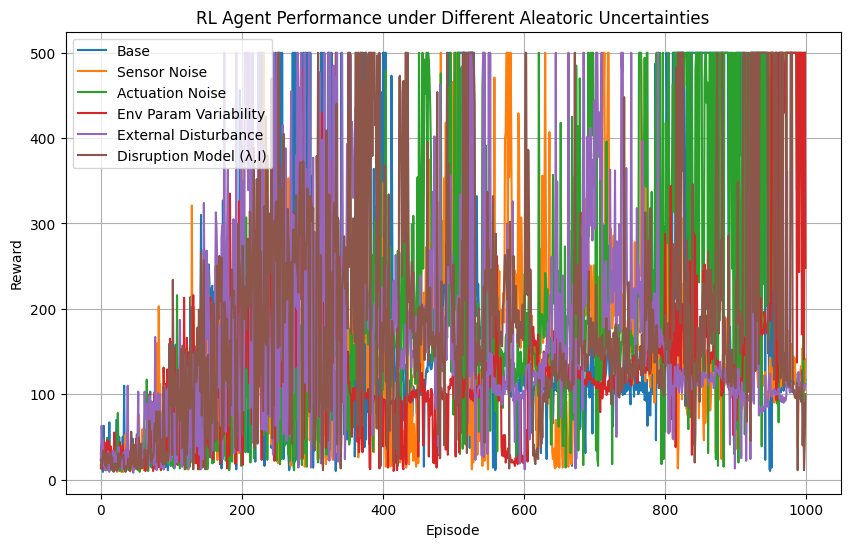

In [ ]:
import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the DQN components
# ------------------------------

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.out = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return np.array(state), action, reward, np.array(next_state), done

    def __len__(self):
        return len(self.buffer)

# -----------------------------------
# 2. Define wrappers for uncertainties
# -----------------------------------

# 2.1 Sensor/Observation Noise: add Gaussian noise to observations.
class SensorNoiseWrapper(gym.ObservationWrapper):
    def __init__(self, env, noise_std=0.1):
        super(SensorNoiseWrapper, self).__init__(env)
        self.noise_std = noise_std

    def observation(self, observation):
        noise = np.random.normal(0, self.noise_std, size=observation.shape)
        return observation + noise

# 2.2 Actuation/Control Noise: flip the chosen action with a certain probability.
class ActuationNoiseWrapper(gym.ActionWrapper):
    def __init__(self, env, flip_prob=0.1):
        super(ActuationNoiseWrapper, self).__init__(env)
        self.flip_prob = flip_prob

    def action(self, action):
        if np.random.rand() < self.flip_prob:
            return 1 - action  # For CartPole, actions are 0 or 1.
        return action

# 2.3 Environmental Parameter Variability:
#     Randomly deposit extra mass along the pole by modifying masspole (and derived quantities) on reset.
class EnvParamVariabilityWrapper(gym.Wrapper):
    def __init__(self, env, extra_mass_range=(0.0, 0.2)):
        super(EnvParamVariabilityWrapper, self).__init__(env)
        self.extra_mass_range = extra_mass_range
        # Get base values from the environment (fallback to known defaults)
        self.base_masspole = env.env.masspole if hasattr(env.env, 'masspole') else 0.1
        self.base_masscart = env.env.masscart if hasattr(env.env, 'masscart') else 1.0
        self.base_length = env.env.length if hasattr(env.env, 'length') else 0.5

    def reset(self, **kwargs):
        observation = self.env.reset(**kwargs)
        extra_mass = np.random.uniform(*self.extra_mass_range)
        if hasattr(self.env.env, 'masspole'):
            self.env.env.masspole = self.base_masspole + extra_mass
            self.env.env.total_mass = self.env.env.masspole + self.base_masscart
            self.env.env.polemass_length = self.env.env.masspole * self.base_length
        return observation

# 2.4 External Disturbances:
#     Simulate wind as a sinusoidal force added to the cart's velocity.
class ExternalDisturbanceWrapper(gym.Wrapper):
    def __init__(self, env, wind_amplitude=1.0, wind_frequency=0.1):
        super(ExternalDisturbanceWrapper, self).__init__(env)
        self.wind_amplitude = wind_amplitude
        self.wind_frequency = wind_frequency
        self.step_count = 0

    def reset(self, **kwargs):
        self.step_count = 0
        return self.env.reset(**kwargs)

    def step(self, action):
        result = self.env.step(action)
        # Handle new/old step API return formats.
        if len(result) == 5:
            obs, reward, done, truncated, info = result
            done = done or truncated
        else:
            obs, reward, done, info = result

        # Compute wind force as a sinusoidal function.
        wind = self.wind_amplitude * np.sin(self.wind_frequency * self.step_count)
        self.step_count += 1

        # Modify the observation: add wind to the cart's velocity (index 1)
        obs_modified = obs.copy()
        obs_modified[1] += wind

        # Update the underlying state if possible.
        if hasattr(self.env.env, 'state'):
            if isinstance(self.env.env.state, tuple):
                state_list = list(self.env.env.state)
                state_list[1] += wind
                self.env.env.state = tuple(state_list)
            else:
                self.env.env.state[1] += wind

        return obs_modified, reward, done, info

# 2.5 Unified Aleatoric Disruption: applies random state perturbations based on λ and I
class DisruptionWrapper(gym.Wrapper):
    def __init__(self, env, lambda_rate=0.1, intensity_vector=None):
        super(DisruptionWrapper, self).__init__(env)
        self.lambda_rate = lambda_rate
        self.intensity_vector = np.array(intensity_vector) if intensity_vector is not None else np.zeros(env.observation_space.shape[0])

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    def step(self, action):
        result = self.env.step(action)
        if len(result) == 5:
            obs, reward, done, truncated, info = result
            done = done or truncated
        else:
            obs, reward, done, info = result

        # Apply disruption with probability λ
        if np.random.rand() < self.lambda_rate:
            noise = np.random.uniform(-self.intensity_vector, self.intensity_vector)
            obs = obs + noise
            # (Optional) Modify underlying env state if applicable
            if hasattr(self.env.env, 'state'):
                self.env.env.state = np.array(self.env.env.state) + noise

        return obs, reward, done, info

# class ExternalDisturbanceWrapper(gym.Wrapper):
#     def __init__(self, env, wind_amplitude=1.0, wind_frequency=0.1):
#         super(ExternalDisturbanceWrapper, self).__init__(env)
#         self.wind_amplitude = wind_amplitude
#         self.wind_frequency = wind_frequency
#         self.step_count = 0

#     def reset(self, **kwargs):
#         self.step_count = 0
#         return self.env.reset(**kwargs)

#     def step(self, action):
#         result = self.env.step(action)
#         # Handle both the new_step_api (5 values) and old (4 values) cases.
#         if len(result) == 5:
#             obs, reward, done, truncated, info = result
#             done = done or truncated
#         else:
#             obs, reward, done, info = result

#         # Compute wind force (sinusoidal disturbance).
#         wind = self.wind_amplitude * np.sin(self.wind_frequency * self.step_count)
#         self.step_count += 1

#         # Modify the observation: add wind to the cart velocity (index 1).
#         obs_modified = obs.copy()
#         obs_modified[1] = obs_modified[1] + wind

#         # If possible, update the underlying state.
#         if hasattr(self.env.env, 'state'):
#             self.env.env.state[1] = self.env.env.state[1] + wind

#         return obs_modified, reward, done, info

# -----------------------------------------
# 3. Training function for the DQN agent
# -----------------------------------------

def train_dqn(env_fn, episodes=200, batch_size=64, gamma=0.99, lr=1e-3,
              epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
              target_update=10, memory_capacity=10000):
    env = env_fn()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy_net = QNetwork(state_dim, action_dim)
    target_net = QNetwork(state_dim, action_dim)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayBuffer(memory_capacity)
    epsilon = epsilon_start

    rewards_history = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            # Epsilon-greedy action selection.
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                with torch.no_grad():
                    q_values = policy_net(state_tensor)
                action = q_values.max(1)[1].item()

            step_result = env.step(action)
            if len(step_result) == 5:
                next_state, reward, done, truncated, _ = step_result
                done = done or truncated
            else:
                next_state, reward, done, _ = step_result

            total_reward += reward
            memory.push(state, action, reward, next_state, done)
            state = next_state

            if len(memory) > batch_size:
                states, actions, rewards, next_states, dones = memory.sample(batch_size)
                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions).unsqueeze(1)
                rewards = torch.FloatTensor(rewards).unsqueeze(1)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones).unsqueeze(1)

                q_values = policy_net(states).gather(1, actions)
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
                expected_q_values = rewards + gamma * next_q_values * (1 - dones)
                loss = nn.MSELoss()(q_values, expected_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())
        rewards_history.append(total_reward)
        print(f"Episode {episode}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")
    env.close()
    return rewards_history

# ------------------------------------------------------
# 4. Create environment functions for each uncertainty
# ------------------------------------------------------

def make_base_env():
    # Base environment (no uncertainty)
    env = gym.make('CartPole-v1', new_step_api=True)
    return env

def make_sensor_noise_env():
    env = gym.make('CartPole-v1', new_step_api=True)
    env = SensorNoiseWrapper(env, noise_std=0.1)
    return env

def make_actuation_noise_env():
    env = gym.make('CartPole-v1', new_step_api=True)
    env = ActuationNoiseWrapper(env, flip_prob=0.1)
    return env

def make_env_param_variability_env():
    env = gym.make('CartPole-v1', new_step_api=True)
    env = EnvParamVariabilityWrapper(env, extra_mass_range=(0.0, 0.2))
    return env

def make_external_disturbance_env():
    env = gym.make('CartPole-v1', new_step_api=True)
    env = ExternalDisturbanceWrapper(env, wind_amplitude=1.0, wind_frequency=0.1)
    return env

def make_disruption_env():
    env = gym.make('CartPole-v1', new_step_api=True)
    lambda_rate = 0.1
    intensity = [0.05, 0.1, 0.05, 0.1]  # Example disruption scale per dimension
    env = DisruptionWrapper(env, lambda_rate=lambda_rate, intensity_vector=intensity)
    return env


# -------------------------------------------------
# 5. Run experiments and collect performance metrics
# -------------------------------------------------

experiments = {
    "Base": make_base_env,
    "Sensor Noise": make_sensor_noise_env,
    "Actuation Noise": make_actuation_noise_env,
    "Env Param Variability": make_env_param_variability_env,
    "External Disturbance": make_external_disturbance_env,
    "Disruption Model (λ,I)": make_disruption_env
}

results = {}
episodes = 1000  # Set training episodes (adjust as needed)

for key, env_fn in experiments.items():
    print(f"\nTraining with {key} uncertainty:")
    rewards = train_dqn(env_fn, episodes=episodes)
    results[key] = rewards

# --------------------------------------
# 6. Plot the training performance curves
# --------------------------------------

plt.figure(figsize=(10, 6))
for key, rewards in results.items():
    plt.plot(rewards, label=key)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("RL Agent Performance under Different Aleatoric Uncertainties")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import plotly.graph_objects as go

# Assume `results` is a dictionary where each key is a label and
# the value is a list (or array) of rewards, e.g.:
# results = {
#     "Base": [...],
#     "Sensor Noise": [...],
#     "Actuation Noise": [...],
#     "Env Param Variability": [...],
#     "External Disturbance": [...]
# }

fig = go.Figure()

for key, rewards in results.items():
    # Create a line trace for each set of rewards
    fig.add_trace(
        go.Scatter(
            x=list(range(len(rewards))),
            y=rewards,
            mode='lines',
            name=key
        )
    )

fig.update_layout(
    title="RL Agent Performance under Different Aleatoric Uncertainties",
    xaxis_title="Episode",
    yaxis_title="Reward",
    template="plotly_white"
)

fig.show()

In [ ]:
import plotly.graph_objects as go

for key, rewards in results.items():
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=list(range(len(rewards))),
            y=rewards,
            mode='lines',
            name=key
        )
    )
    fig.update_layout(
        title=f"RL Agent Performance - {key}",
        xaxis_title="Episode",
        yaxis_title="Reward",
        template="plotly_white"
    )
    fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np

def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

fig = go.Figure()

for key, rewards in results.items():
    smoothed = moving_average(rewards, window_size=10)

    # Raw rewards (faded for clarity)
    fig.add_trace(
        go.Scatter(
            x=list(range(len(rewards))),
            y=rewards,
            mode='lines',
            name=f"{key} (Raw)",
            opacity=0.3,
            line=dict(dash='dot')
        )
    )

    # Smoothed rewards
    fig.add_trace(
        go.Scatter(
            x=list(range(len(smoothed))),
            y=smoothed,
            mode='lines',
            name=f"{key} (Smoothed)"
        )
    )

fig.update_layout(
    title="RL Agent Performance under Different Aleatoric Uncertainties",
    xaxis_title="Episode",
    yaxis_title="Reward",
    template="plotly_white",
    legend_title="Uncertainty Type"
)

fig.show()


In [ ]:
import plotly.graph_objects as go
import numpy as np
import plotly.express as px

def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Use a qualitative color palette with enough distinct colors
color_palette = px.colors.qualitative.Set1  # You can also try: Plotly, D3, Pastel

fig = go.Figure()
num_colors = len(color_palette)
i = 0

for key, rewards in results.items():
    smoothed = moving_average(rewards, window_size=10)
    color = color_palette[i % num_colors]
    i += 1

    # Raw rewards (faded)
    fig.add_trace(
        go.Scatter(
            x=list(range(len(rewards))),
            y=rewards,
            mode='lines',
            name=f"{key} (Raw)",
            opacity=0.3,
            line=dict(color=color, dash='dot')
        )
    )

    # Smoothed rewards
    fig.add_trace(
        go.Scatter(
            x=list(range(len(smoothed))),
            y=smoothed,
            mode='lines',
            name=f"{key} (Smoothed)",
            line=dict(color=color)
        )
    )

fig.update_layout(
    title="RL Agent Performance under Different Aleatoric Uncertainties",
    xaxis_title="Episode",
    yaxis_title="Reward",
    template="plotly_white",
    legend_title="Uncertainty Type"
)

fig.show()


In [ ]:
!pip list